[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/mhuertascompany/euclid-school-2025/blob/main/Y1/notebooks/euclidzoo_cnn_vit.ipynb)

# Galaxy zoo image classification - basics with PyTorch
## Ecole Rodolphe Cledassou 2025

> Marc Huertas-Company & Hubert Bretonnière 

This notebook illustrates how to train a simple CNN and ViT from scratch to estimate the morphologies of galaxies observed with the Euclid Space Telescope. The training set is composed of galaxy stamps labeled by visual inspection through citizen science

In [2]:
# --- EUCLID SCHOOL: COLAB / LOCAL BOOTSTRAP ---------------------------------
# If on Colab, installs minimal deps, clones repo (if needed), cd's into
# Y1/notebooks, downloads a *ZIP* dataset, and unzips it to ./zoo-data.
# If local, it just ensures we're in Y1/notebooks and downloads if missing.
# ----------------------------------------------------------------------------
import os, sys, zipfile, subprocess
from pathlib import Path
from urllib.request import urlretrieve

# ---- Config
REPO_URL   = "https://github.com/mhuertascompany/euclid-school-2025.git"
COLAB_ROOT = Path("/content")
REPO_NAME  = "euclid-school-2025"
NOTE_DIR   = Path("Y1/notebooks")           # where we want zoo-data/
ZIP_URL    = "https://astdp.net/euclid-zoo-data"   # serves a ZIP file
ZIP_NAME   = "euclid-zoo-data.zip"

# Minimal pip deps for Colab (PyTorch is already preinstalled there)
NEEDED_PIP = [
    "datasets==4.*", "transformers==4.*", "timm==1.*", "albumentations==2.*",
    "lightning==2.*", "pytorch-lightning==2.*", "einops==0.*", "pyarrow",
    "seaborn", "umap-learn", "nflows", "tensorboard", "tqdm", "safetensors",
    "opencv-python"
]

def in_colab():
    try:
        import google.colab  # type: ignore
        return True
    except Exception:
        return False

def ensure_repo_and_chdir_to_notebooks():
    """
    If running in Colab: clone repo under /content and cd into Y1/notebooks.
    If local: try to cd into Y1/notebooks relative to the repo root.
    """
    if in_colab():
        # Clone repo if not present
        repo_dir = COLAB_ROOT / REPO_NAME
        if not repo_dir.exists():
            print("Cloning repo…")
            subprocess.run(["git", "clone", "-q", REPO_URL, str(repo_dir)], check=True)
        target = repo_dir / NOTE_DIR
        os.chdir(target)
    else:
        # Local: if we're not already inside Y1/notebooks, try to go there
        cwd = Path.cwd()
        if cwd.name != "notebooks" or cwd.parent.name != "Y1":
            if (cwd / NOTE_DIR).exists():
                os.chdir(cwd / NOTE_DIR)
            else:
                # Try walking up a bit to find the repo root
                p = cwd
                for _ in range(5):
                    if (p / NOTE_DIR).exists():
                        os.chdir(p / NOTE_DIR)
                        break
                    p = p.parent
    print("Working directory:", Path.cwd())

def pip_install_if_colab():
    if in_colab():
        print("Installing minimal pip deps for Colab…")
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", "--upgrade", *NEEDED_PIP], check=True)

def download_and_unzip_if_needed():
    """
    Download the ZIP to Y1/notebooks and unzip to ./zoo-data if not present.
    Assumes the ZIP either contains a top-level 'zoo-data/' or files/folders
    that should live under 'zoo-data/'.
    """
    note_dir = Path.cwd()
    zoo_dir = note_dir / "zoo-data"
    if zoo_dir.exists() and any(zoo_dir.iterdir()):
        print("zoo-data already present ✓")
        return
    zip_path = note_dir / ZIP_NAME
    print(f"Downloading dataset ZIP to: {zip_path}")
    urlretrieve(ZIP_URL, zip_path)
    print("Extracting…")
    with zipfile.ZipFile(zip_path, "r") as zf:
        # Try extracting; if the ZIP already contains 'zoo-data/', we're done.
        # Otherwise extract to a temp and move/merge into ./zoo-data.
        top_names = {Path(i.filename).parts[0] for i in zf.infolist() if not i.is_dir()}
        if "zoo-data" in top_names:
            zf.extractall(note_dir)
        else:
            tmp = note_dir / "_tmp_zoo_extract"
            tmp.mkdir(exist_ok=True)
            zf.extractall(tmp)
            zoo_dir.mkdir(exist_ok=True)
            # Move everything under tmp into zoo-data
            for p in tmp.iterdir():
                # if zip contains a single folder, merge its content
                if p.is_dir() and p.name == "zoo-data":
                    for q in p.iterdir():
                        q.rename(zoo_dir / q.name)
                else:
                    p.rename(zoo_dir / p.name)
            tmp.rmdir()
    print("Done. Data available under ./zoo-data")

def print_device_info():
    import torch
    print("\nPyTorch:")
    print("  version:", torch.__version__)
    
    device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()  # for completeness (Linux/Windows)
    else torch.device("cpu")
    )
    print("Using:", device)
    if in_colab():
        try: subprocess.run(["nvidia-smi"], check=False)
        except Exception: pass

# Run
if in_colab():
    print("Running on Google Colab ✓")
else:
    print("Running locally")

pip_install_if_colab()
ensure_repo_and_chdir_to_notebooks()
download_and_unzip_if_needed()
print_device_info()

Running locally
Working directory: /Users/marchuertascompany/Documents/teaching/EUCLID_school/2025/euclid-school-2025/Y1/notebooks
zoo-data already present ✓

PyTorch:
  version: 2.5.1
Using: mps


## Loading and exploring the datasets

The data can be found in https://astdp.net/euclid-zoo-data

Unzip it locally and update the `PATH_TO_DATADIR` according to your system.  
Otherwise use the second method to load directly from the URL.

In [41]:
import torch
import numpy as np
import os, shutil, glob

from datasets import load_dataset,disable_caching

PATH_TO_DATADIR = "zoo-data"

import os, shutil, glob
from datasets import load_dataset

# 1) Remove global caches of imagefolder
hf_home = os.path.expanduser("~/.cache/huggingface/datasets")
for p in glob.glob(os.path.join(hf_home, "imagefolder", "default-*")):
    print("Removing global cache:", p)
    shutil.rmtree(p, ignore_errors=True)

# 2) Remove your project-local cache as well
local_cache = os.path.abspath("./.hf_cache")
print("Removing local cache:", local_cache)
shutil.rmtree(local_cache, ignore_errors=True)
os.makedirs(local_cache, exist_ok=True)

# 3) Rebuild clean
ds = load_dataset(
    "imagefolder",
    data_files={
        "train": ["zoo-data/train/*/*"],
        "test":  ["zoo-data/test/*/*"],
    },
    drop_labels=False,
    keep_in_memory=False,
    cache_dir=local_cache,
    download_mode="force_redownload",   # force a full rebuild
)
train_set, test_set = ds["train"], ds["test"]
print(train_set, test_set)

class_names = train_set.features["label"].names
# Attach a .classes attribute to both splits
for split in ("train", "test"):
    setattr(ds[split], "classes", class_names)


print(train_set.classes)
print(test_set.classes)

globals()["train_dataset_plot"] = train_set

Removing local cache: /Users/marchuertascompany/Documents/teaching/EUCLID_school/2025/euclid-school-2025/Y1/notebooks/.hf_cache


Generating train split: 2760 examples [00:00, 27570.77 examples/s]
Generating test split: 691 examples [00:00, 27739.89 examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 2760
}) Dataset({
    features: ['image', 'label'],
    num_rows: 691
})
['featured', 'problem', 'smooth']
['featured', 'problem', 'smooth']


In [42]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
batch_size = 9

# 1) Define transforms (resize to fixed size, to tensor, normalize optional)
IMG_SIZE = 224  # or whatever your model expects
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),                           # PIL -> [C,H,W] float in [0,1]
    # transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),  # optional
])

# 2) Collate converts PIL -> tensor (+ labels)
def collate_fn(examples):
    # If images can be grayscale, force RGB for consistent 3 channels:
    imgs = [tfm(ex["image"].convert("RGB")) for ex in examples]
    labels = torch.tensor([ex["label"] for ex in examples], dtype=torch.long)
    return torch.stack(imgs, 0), labels



trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, collate_fn=collate_fn)

testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, collate_fn=collate_fn)

globals()["train_loader_plot"] = trainloader

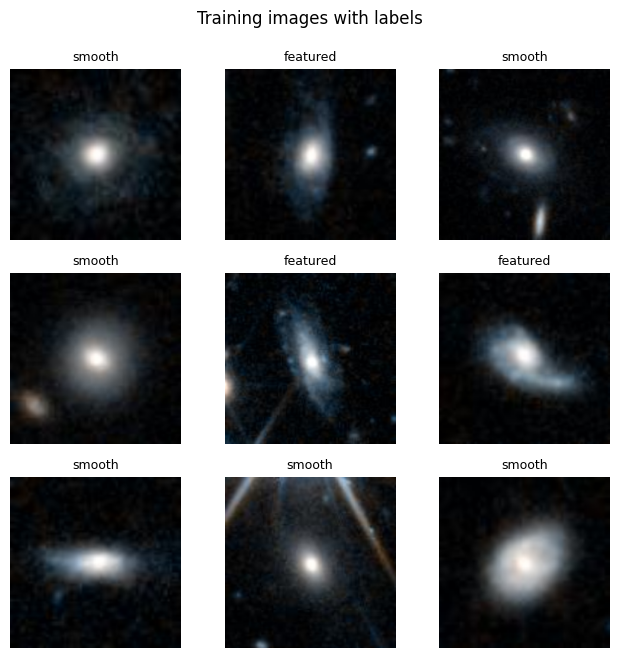

In [43]:
import torch, numpy as np, matplotlib.pyplot as plt


g = globals()

train_loader = g.get('train_loader_plot') or g.get('train_dataloader') or g.get('loader_train') or g.get('train_dl')
train_dataset = g.get('train_dataset_plot') or g.get('train_ds') or (train_loader.dataset if train_loader is not None and hasattr(train_loader, 'dataset') else None)
assert train_dataset is not None, "Could not locate a training dataset/loader. Please run the data prep cell first."

def label_name(y):
    if hasattr(train_dataset, 'classes'):
        try: return str(train_dataset.classes[int(y)])
        except: return str(y)
    if hasattr(train_dataset, 'class_to_idx'):
        rev = {v:k for k,v in train_dataset.class_to_idx.items()}
        return str(rev.get(int(y), y))
    return str(int(y))

if train_loader is not None:
    images, labels = next(iter(train_loader))
else:
    idx = torch.randperm(len(train_dataset))[:64]
    samples = [train_dataset[i] for i in idx]
    images = torch.stack([s[0] if torch.is_tensor(s[0]) else torchvision.transforms.functional.to_tensor(s[0]) for s in samples])
    labels = torch.tensor([int(s[1]) for s in samples])

B = min(images.shape[0], 64)
R = C = int(np.ceil(np.sqrt(B)))
fig, axes = plt.subplots(R, C, figsize=(2.2*C, 2.2*R))
axes = np.array(axes).reshape(R, C)

def to_display(img):
    x = img.detach().cpu().float()
    if x.ndim == 3 and x.shape[0] in (1,3):
        if x.min() < -0.1 or x.max() > 1.1:
            x = x * 0.5 + 0.5
        x = x.clamp(0,1)
        if x.shape[0] == 1: return x.squeeze(0).numpy(), 'gray'
        else: return np.transpose(x.numpy(), (1,2,0)), None
    return x.numpy(), 'gray'

for i in range(R*C):
    ax = axes[i//C, i% C]
    ax.axis('off')
    if i >= B: continue
    img, cmap = to_display(images[i])
    ax.imshow(img, cmap=cmap)
    ax.set_title(label_name(labels[i]), fontsize=9)

plt.suptitle("Training images with labels", y=0.99)
plt.tight_layout(); plt.show()

## Defining data augmentations

This will use the transformations defined in https://albumentations.ai/docs/ to augment the datasets

In [44]:
import albumentations as A
import cv2
import numpy as np

data_augmentation_pipeline = A.Compose([
    A.Rotate(
        limit=180,
        interpolation=cv2.INTER_LINEAR,
        border_mode=cv2.BORDER_CONSTANT,
        value=(0, 0, 0),         # fill color if you rotate out of frame (RGB)
        always_apply=True
    ),
    A.RandomResizedCrop(
        size=(224, 224),         # v2: use size=(H, W)
        scale=(0.7, 0.8),
        ratio=(0.9, 1.1),
        interpolation=cv2.INTER_LINEAR,
        always_apply=True
    ),
    A.VerticalFlip(p=0.5),
    A.ToFloat(max_value=255.0, always_apply=True),
])

def augment_func(samples):
    samples["pixel_values"] = [
        data_augmentation_pipeline(image=np.array(img.convert("RGB")))["image"]
        for img in samples["image"]
    ]
    return samples

train_set.set_transform(augment_func)
globals()["train_dataset"] = train_set


/var/folders/3b/tyyj2qy12lxcqm59_rgl14bh0000gn/T/ipykernel_82613/3296971643.py:6: UserWarning: Argument(s) 'value, always_apply' are not valid for transform Rotate
  A.Rotate(
/var/folders/3b/tyyj2qy12lxcqm59_rgl14bh0000gn/T/ipykernel_82613/3296971643.py:13: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomResizedCrop
  A.RandomResizedCrop(
/var/folders/3b/tyyj2qy12lxcqm59_rgl14bh0000gn/T/ipykernel_82613/3296971643.py:21: UserWarning: Argument(s) 'always_apply' are not valid for transform ToFloat
  A.ToFloat(max_value=255.0, always_apply=True),


However we don't want these augmentations to be applied to the test images. We only want to standardize them.

In [45]:

standardization_pipeline = A.Compose([
    A.Resize(height=224, width=224, interpolation=1), 
    A.ToFloat(max_value=255.0, always_apply=True),
])

def standardize_func(samples):
    samples["pixel_values"] = [
        standardization_pipeline(image=np.array(image))["image"] for image in samples["image"]
    ]
    return samples

test_set.set_transform(standardize_func)

/var/folders/3b/tyyj2qy12lxcqm59_rgl14bh0000gn/T/ipykernel_82613/2571306777.py:3: UserWarning: Argument(s) 'always_apply' are not valid for transform ToFloat
  A.ToFloat(max_value=255.0, always_apply=True),


## Creating a convolutional network to extract features from the images from scratch

In [48]:
import torch.nn as nn
import torch.nn.functional as F

device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()  # for completeness (Linux/Windows)
    else torch.device("cpu")
)
print("Using:", device)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 4)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


cnn_model = Net().to(device)

Using: mps


The loss function for this classification problem will be a cross entropy loss.

We also set up the optimizer for the training phase.

In [ ]:
import torch.optim as optim

LEARNING_RATE = 1e-4

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=LEARNING_RATE, momentum=0.9)

Before we start training, we can create a dataloader that will take the sample images from the dataset by batch of `batch_size`, apply the data augmentation and feed them to the neural network following a scheme defined in the `collate_fn` function below.

In [51]:
batch_size = 8

def collate_fn(examples):
    pixel_values = torch.stack([torch.tensor(example["pixel_values"]) for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return  pixel_values.permute(0, 3, 1, 2), labels

trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, collate_fn=collate_fn)

testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, collate_fn=collate_fn)


globals()["train_loader"] = trainloader
globals()["val_loader"] = testloader


## Training

This is the training script that will run for a number of epochs

In [ ]:
N_EPOCHS = 20
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()  # for completeness (Linux/Windows)
    else torch.device("cpu")
)
print("Using:", device)

for epoch in range(N_EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn_model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 0:
            print(f'Epoch {epoch + 1:2d}, batch {i + 1:3d}] | loss: {running_loss / 30:.3f}')
            running_loss = 0.0

print('Finished Training')

Using: mps
Epoch  1, batch   1] | loss: 0.025
Epoch  1, batch  31] | loss: 0.852
Epoch  1, batch  61] | loss: 0.812
Epoch  1, batch  91] | loss: 0.744
Epoch  1, batch 121] | loss: 0.835
Epoch  1, batch 151] | loss: 0.824
Epoch  1, batch 181] | loss: 0.870
Epoch  1, batch 211] | loss: 0.805
Epoch  1, batch 241] | loss: 0.854
Epoch  1, batch 271] | loss: 0.811
Epoch  1, batch 301] | loss: 0.838
Epoch  1, batch 331] | loss: 0.841
Epoch  2, batch   1] | loss: 0.025
Epoch  2, batch  31] | loss: 0.825
Epoch  2, batch  61] | loss: 0.829
Epoch  2, batch  91] | loss: 0.884
Epoch  2, batch 121] | loss: 0.797
Epoch  2, batch 151] | loss: 0.805
Epoch  2, batch 181] | loss: 0.845
Epoch  2, batch 211] | loss: 0.775
Epoch  2, batch 241] | loss: 0.834
Epoch  2, batch 271] | loss: 0.862
Epoch  2, batch 301] | loss: 0.793
Epoch  2, batch 331] | loss: 0.773
Epoch  3, batch   1] | loss: 0.027
Epoch  3, batch  31] | loss: 0.818
Epoch  3, batch  61] | loss: 0.813
Epoch  3, batch  91] | loss: 0.849
Epoch  3,

After training we can save the model state into a file so we can load it back again later.

In [ ]:
torch.save(cnn_model.state_dict(), 'convnet.pth')

## Model evaluation

Finally we can evaluate the network on the test data

In [26]:
correct = 0
total = 0
y_true = np.array([])
y_pred = np.array([])
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true = np.concatenate([y_true, np.array(labels)])
        y_pred = np.concatenate([y_pred, np.array(predicted)])

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

/var/folders/3b/tyyj2qy12lxcqm59_rgl14bh0000gn/T/ipykernel_82613/3862333603.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_true = np.concatenate([y_true, np.array(labels)])
/var/folders/3b/tyyj2qy12lxcqm59_rgl14bh0000gn/T/ipykernel_82613/3862333603.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.concatenate([y_pred, np.array(predicted)])


Accuracy of the network on the test images: 54 %


## 🧠 Train a tiny ViT **from scratch** (analogous to the CNN)

This defines a small ViT and trains it using the same data loaders. It uses sinusoidal 2D positional
embeddings so it works with arbitrary image sizes (no fixed 224×224 assumption).

In [47]:
import math, time, torch, torch.nn as nn, torch.nn.functional as F
import torchvision

device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()  # for completeness (Linux/Windows)
    else torch.device("cpu")
)
print("Using:", device)

g = globals()
train_loader = g.get('train_loader') or g.get('train_dataloader') or g.get('loader_train') or g.get('train_dl')
val_loader   = g.get('val_loader') or g.get('valid_loader') or g.get('loader_val') or g.get('loader_valid')
train_dataset = g.get('train_dataset') or (train_loader.dataset if train_loader is not None else None)

assert train_loader is not None, "Need a training DataLoader named train_loader (or similar)."

def infer_num_classes(ds):
    if hasattr(ds, 'classes'): return len(ds.classes)
    if hasattr(ds, 'class_to_idx'): return len(ds.class_to_idx)
    X,Y = next(iter(train_loader))
    return int(max(Y).item()) + 1

num_classes = g.get('num_classes') or (infer_num_classes(train_dataset) if train_dataset is not None else infer_num_classes(None))
epochs_vit  = g.get('epochs') or 10
lr_vit      = 3e-4

class PatchEmbed(nn.Module):
    def __init__(self, in_ch=3, embed_dim=192, patch=8):
        super().__init__()
        self.patch = patch
        self.proj = nn.Conv2d(in_ch, embed_dim, kernel_size=patch, stride=patch)
    def forward(self, x):
        x = self.proj(x)
        B, D, H, W = x.shape
        x = x.flatten(2).transpose(1,2)
        return x, (H, W)

def sinusoidal_2d(h, w, dim):
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing='ij')
    y = y.flatten().float(); x = x.flatten().float()
    assert dim % 4 == 0, "dim must be multiple of 4"
    dim_half = dim // 4
    wy = 1.0 / (10000 ** (torch.arange(dim_half).float() / dim_half))
    wx = 1.0 / (10000 ** (torch.arange(dim_half).float() / dim_half))
    out = []
    for i in range(dim_half):
        out += [torch.sin(y * wy[i]), torch.cos(y * wy[i])]
    for i in range(dim_half):
        out += [torch.sin(x * wx[i]), torch.cos(x * wx[i])]
    pe = torch.stack(out, dim=1)
    return pe

class MLP(nn.Module):
    def __init__(self, dim, hidden_mult=4, drop=0.0):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim*hidden_mult)
        self.fc2 = nn.Linear(dim*hidden_mult, dim)
        self.act = nn.GELU()
        self.drop = nn.Dropout(drop)
    def forward(self, x):
        x = self.fc1(x); x = self.act(x); x = self.drop(x)
        x = self.fc2(x); x = self.drop(x); return x

class Block(nn.Module):
    def __init__(self, dim, heads=3, drop=0.0, mlp_mult=4):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = nn.MultiheadAttention(dim, num_heads=heads, batch_first=True, dropout=drop)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp   = MLP(dim, mlp_mult, drop)
    def forward(self, x):
        h = x; x = self.norm1(x)
        x, _ = self.attn(x, x, x, need_weights=False); x = x + h
        h = x; x = self.norm2(x)
        x = self.mlp(x); x = x + h
        return x

class TinyViT(nn.Module):
    def __init__(self, in_ch=3, num_classes=10, embed_dim=128, depth=6, heads=4, patch=8, drop=0.0):
        super().__init__()
        self.embed = PatchEmbed(in_ch, embed_dim, patch)
        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos_drop = nn.Dropout(drop)
        self.blocks = nn.ModuleList([Block(embed_dim, heads, drop) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
    def forward(self, x):
        B, C, H, W = x.shape
        x, (h, w) = self.embed(x)
        pe = sinusoidal_2d(h, w, x.shape[-1]).to(x.device)
        pe = pe.unsqueeze(0).expand(B, -1, -1)
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        pe_cls = torch.zeros(B, 1, x.shape[-1], device=x.device)
        x = x + torch.cat([pe_cls, pe], dim=1)
        x = self.pos_drop(x)
        for blk in self.blocks: x = blk(x)
        x = self.norm(x)[:,0]
        return self.head(x)

try:
    sample_x, _ = next(iter(train_loader))
    in_ch = sample_x.shape[1]
except:
    in_ch = 3

vit_model = TinyViT(in_ch=in_ch, num_classes=num_classes, embed_dim=128, depth=6, heads=4, patch=8, drop=0.0).to(device)
opt = torch.optim.AdamW(vit_model.parameters(), lr=lr_vit, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader):
    model.train(); total=correct=0; loss_sum=0.0
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        logits = model(X); loss = criterion(logits,y)
        opt.zero_grad(); loss.backward(); opt.step()
        loss_sum += loss.item()*X.size(0)
        pred = logits.argmax(1); total += y.size(0); correct += (pred==y).sum().item()
    return loss_sum/total, correct/total

@torch.no_grad()
def eval_accuracy(model, loader):
    model.eval(); total=correct=0; loss_sum=0.0
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        logits = model(X); loss = criterion(logits,y)
        loss_sum += loss.item()*X.size(0)
        pred = logits.argmax(1); total += y.size(0); correct += (pred==y).sum().item()
    return loss_sum/total, correct/total

print(f"Training TinyViT from scratch for {epochs_vit} epochs on device: {device}")
vit_history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
for ep in range(1, epochs_vit+1):
    tr_loss, tr_acc = train_one_epoch(vit_model, train_loader)
    if val_loader is not None:
        va_loss, va_acc = eval_accuracy(vit_model, val_loader)
    else:
        va_loss, va_acc = float('nan'), float('nan')
    vit_history["train_loss"].append(tr_loss); vit_history["train_acc"].append(tr_acc)
    vit_history["val_loss"].append(va_loss);   vit_history["val_acc"].append(va_acc)
    print(f"[ViT][{ep:03d}/{epochs_vit}] train loss={tr_loss:.4f} acc={tr_acc:.4f} | val loss={va_loss:.4f} acc={va_acc:.4f}")

Using: mps
Training TinyViT from scratch for 10 epochs on device: mps
[ViT][001/10] train loss=0.8399 acc=0.4819 | val loss=nan acc=nan
[ViT][002/10] train loss=0.8239 acc=0.5054 | val loss=nan acc=nan
[ViT][003/10] train loss=0.7768 acc=0.5688 | val loss=nan acc=nan
[ViT][004/10] train loss=0.7176 acc=0.6232 | val loss=nan acc=nan
[ViT][005/10] train loss=0.6710 acc=0.6772 | val loss=nan acc=nan
[ViT][006/10] train loss=0.6465 acc=0.6935 | val loss=nan acc=nan
[ViT][007/10] train loss=0.6243 acc=0.7011 | val loss=nan acc=nan
[ViT][008/10] train loss=0.6048 acc=0.7159 | val loss=nan acc=nan
[ViT][009/10] train loss=0.5875 acc=0.7185 | val loss=nan acc=nan
[ViT][010/10] train loss=0.5733 acc=0.7250 | val loss=nan acc=nan


In [50]:
torch.save(vit_model.state_dict(), 'vit.pth')

## 📊 Compare CNN vs ViT results

This cell looks for a CNN model defined earlier (e.g., `cnn_model` or `model`) and compares its validation accuracy to the newly trained `vit_model`.

In [54]:
import torch

device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()  # for completeness (Linux/Windows)
    else torch.device("cpu")
)
print("Using:", device)

cnn_model = Net().to(device)
cnn_model.load_state_dict(torch.load('convnet.pth'))

vit_model = TinyViT(in_ch=in_ch, num_classes=num_classes, embed_dim=128, depth=6, heads=4, patch=8, drop=0.0).to(device)
vit_model.load_state_dict(torch.load('vit.pth'))


assert vit_model is not None, "No vit_model found. Please run the ViT cell first."
assert cnn_model is not None, "No cnn_model found. Please run the CNN cell first."

val_loader = globals().get('val_loader') or globals().get('valid_loader') or globals().get('loader_val') or globals().get('loader_valid') or globals().get('train_loader')
assert val_loader is not None, "Need a validation (or training) DataLoader to compare."

@torch.no_grad()
def accuracy(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval(); total=correct=0; loss_sum=0.0
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        logits = model(X); loss = criterion(logits,y)
        loss_sum += loss.item()*X.size(0)
        pred = logits.argmax(1); total += y.size(0); correct += (pred==y).sum().item()
    return loss_sum/total, correct/total

vit_val_loss, vit_val_acc = accuracy(vit_model, val_loader)
if cnn_model is not None:
    cnn_val_loss, cnn_val_acc = accuracy(cnn_model, val_loader)
else:
    cnn_val_loss, cnn_val_acc = float('nan'), float('nan')

print("Validation comparison:")
print(f"  CNN: loss={cnn_val_loss:.4f}, acc={cnn_val_acc:.4f}")
print(f"  ViT: loss={vit_val_loss:.4f}, acc={vit_val_acc:.4f}")

Using: mps


/var/folders/3b/tyyj2qy12lxcqm59_rgl14bh0000gn/T/ipykernel_82613/1854833127.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load('convne

Validation comparison:
  CNN: loss=0.7451, acc=0.5412
  ViT: loss=0.6139, acc=0.6990


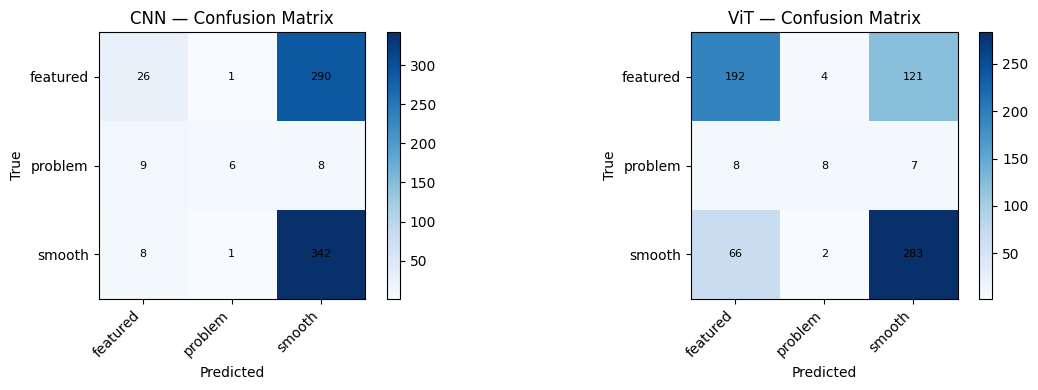

In [55]:
# --- Confusion matrices for CNN & ViT ---

import numpy as np
import matplotlib.pyplot as plt

@torch.no_grad()
def get_predictions(model, loader, device):
    model.eval()
    all_true, all_pred = [], []
    for X, y in loader:
        X = X.to(device)
        logits = model(X)
        pred = logits.argmax(1).cpu()
        all_true.append(y.cpu())
        all_pred.append(pred)
    y_true = torch.cat(all_true).numpy()
    y_pred = torch.cat(all_pred).numpy()
    return y_true, y_pred

y_true_vit, y_pred_vit = get_predictions(vit_model, val_loader, device)
y_true_cnn, y_pred_cnn = get_predictions(cnn_model, val_loader, device)

# Try to get human-readable class names; otherwise fall back to indices
display_labels = None
try:
    # Hugging Face datasets: names live here
    display_labels = train_set.features["label"].names
except Exception:
    pass
if display_labels is None:
    ds = getattr(val_loader, "dataset", None)
    if ds is not None and hasattr(ds, "classes"):
        display_labels = list(ds.classes)
if display_labels is None:
    # fallback: numeric class ids from targets
    K = int(max(y_true_vit.max(), y_true_cnn.max())) + 1
    display_labels = [str(i) for i in range(K)]

def confusion_matrix_np(y_true, y_pred, num_classes=None):
    if num_classes is None:
        num_classes = int(max(y_true.max(), y_pred.max())) + 1
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    return cm

def plot_confusion_matrix(cm, labels, title, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    # write counts
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center", fontsize=8)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Build and plot side-by-side
num_classes = len(display_labels)
cm_cnn = confusion_matrix_np(y_true_cnn, y_pred_cnn, num_classes)
cm_vit = confusion_matrix_np(y_true_vit, y_pred_vit, num_classes)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_confusion_matrix(cm_cnn, display_labels, "CNN — Confusion Matrix", ax=axes[0])
plot_confusion_matrix(cm_vit, display_labels, "ViT — Confusion Matrix", ax=axes[1])
plt.tight_layout()
plt.show()


## Exercices

You job, if you accept it, is to improve the accuracy of the model.

To do so, here are some ideas:
- try new data augmentations from the Albumentations package (https://albumentations.ai/docs/)
- explore new CNN or ViTarchitectures found on the web (GitHub, Kaggle, arXiv..)
- look at the effect of the learning rate, epochs and batch_size on the training loss